In [35]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from langdetect import detect, DetectorFactory, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Download stopwords (only once, NLTK needs the resource)

nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eppuhenriksson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Download NLTK lexicon (only needed once)
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eppuhenriksson/nltk_data...


True

### Analysis of Booking reviews

In [66]:
# -----------------------
# 1. Load dataset
# -----------------------

df = pd.read_csv("hotel_reviews.csv")
print(df.shape)
display(df.head())

(515738, 17)


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [46]:
# Separate positive and negative reviews 
# Booking dataset uses "No Positive" / "No Negative" when the review is missing

df_pos = df[df['Positive_Review'] != "No Positive"]['Positive_Review']
df_neg = df[df['Negative_Review'] != "No Negative"]['Negative_Review']

#### Single word

In [47]:
# Add custom stopwords to remove common but uninformative words that are too generic

extra_stopwords = [
    "amazing", "good", "comfy", "everything", "excellent", "great", "lovely", 
    "nice", "hotel", "perfect", "really", "room", "rooms", "us", "well", "fantastic",
    "also", "bit", "could", "even", "get", "stay", "time", "would", "one", "london"
]

stop_words1 = stopwords.words("english") + extra_stopwords

In [48]:
# Text cleaning function

def clean_text_extra(text):
    """
    Cleans the input text by:
    - Lowercasing all words
    - Removing punctuation/numbers (keep only letters and spaces)
    - Removing stopwords (common words like 'the', 'is', 'and')
    """
    text = text.lower()                               # lowercase
    text = re.sub(r"[^a-z\s]", "", text)              # keep only letters + spaces
    tokens = [w for w in text.split() if w not in stop_words1]  # remove stopwords
    return " ".join(tokens)

# Apply cleaning function to both positive and negative reviews

df_pos_clean = df_pos.apply(clean_text_extra)
df_neg_clean = df_neg.apply(clean_text_extra)

In [49]:
# TF-IDF analysis (find most "important" words)
# TF-IDF (Term Frequency - Inverse Document Frequency):
# Highlights words that appear frequently in reviews but are not common everywhere.

vectorizer = TfidfVectorizer(max_features=30)  # only keep top 30 words

# Positive reviews

X_pos = vectorizer.fit_transform(df_pos_clean)
pos_words_b = vectorizer.get_feature_names_out()

# Negative reviews

X_neg = vectorizer.fit_transform(df_neg_clean)
neg_words_b = vectorizer.get_feature_names_out()

print("Top Positive Keywords (TF-IDF):")
print(pos_words_b)

print("\nTop Negative Keywords (TF-IDF):")
print(neg_words_b)

Top Positive Keywords (TF-IDF):
['area' 'bar' 'bathroom' 'beautiful' 'bed' 'beds' 'breakfast' 'central'
 'city' 'clean' 'close' 'comfortable' 'easy' 'facilities' 'food' 'free'
 'friendly' 'helpful' 'location' 'metro' 'modern' 'quiet' 'reception'
 'restaurant' 'service' 'spacious' 'staff' 'station' 'view' 'walk']

Top Negative Keywords (TF-IDF):
['air' 'bar' 'bathroom' 'bed' 'better' 'breakfast' 'check' 'coffee' 'day'
 'door' 'expensive' 'floor' 'hot' 'like' 'little' 'night' 'noise' 'noisy'
 'nothing' 'poor' 'price' 'quite' 'reception' 'service' 'shower' 'small'
 'staff' 'water' 'wifi' 'work']


In [50]:
# Word Frequency analysis
# CountVectorizer counts raw frequency (no weighting).
# This shows what words appear the most often.

count_vectorizer = CountVectorizer(max_features=20)

# Positive reviews

pos_counts = count_vectorizer.fit_transform(df_pos_clean)
pos_top_b = pd.DataFrame({
    'word': count_vectorizer.get_feature_names_out(),
    'count': np.asarray(pos_counts.sum(axis=0)).ravel()
}).sort_values(by="count", ascending=False)

# Negative reviews

neg_counts = count_vectorizer.fit_transform(df_neg_clean)
neg_top_b = pd.DataFrame({
    'word': count_vectorizer.get_feature_names_out(),
    'count': np.asarray(neg_counts.sum(axis=0)).ravel()
}).sort_values(by="count", ascending=False)

print("Most Frequent Positive Words:")
print(pos_top_b)

print("\nMost Frequent Negative Words:")
print(neg_top_b)

Most Frequent Positive Words:
           word   count
16        staff  194574
10     location  192857
8      friendly   85353
3     breakfast   84581
9       helpful   76183
4         clean   66930
6   comfortable   59952
2           bed   49928
5         close   30971
17      station   29312
15      service   25822
13        quiet   21914
19         walk   20469
0           bar   19571
1      bathroom   17415
18         view   17262
12       modern   16890
7          food   16344
11        metro   16082
14    reception   15901

Most Frequent Negative Words:
         word  count
3   breakfast  58478
17      small  49883
18      staff  39512
11    nothing  38769
2         bed  29834
1    bathroom  26585
10      night  24083
9      little  22536
8        like  22445
16     shower  21290
15    service  19323
0         bar  19132
14  reception  16646
6   expensive  16543
12       poor  16104
4       check  15367
13      price  15280
5         day  15176
7       floor  14951
19      water  

#### Analyze bigrams & trigrams

In [54]:
# Cleaning function

def clean_text(text):
    """
    Lowercases, removes punctuation/numbers, and filters stopwords.
    """
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

# Apply cleaning function to both positive and negative reviews

df_pos_clean = df_pos.apply(clean_text)
df_neg_clean = df_neg.apply(clean_text)

In [55]:
# Function to extract n-grams

def get_top_ngrams(corpus, n=2, top_k=20):
    """
    Extracts top_k n-grams from text corpus using CountVectorizer.
    - n=2 → bigrams
    - n=3 → trigrams
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]


In [56]:
# Extract top bigrams and trigrams

top_pos_bigrams_b = get_top_ngrams(df_pos_clean, n=2, top_k=20)
top_neg_bigrams_b = get_top_ngrams(df_neg_clean, n=2, top_k=20)

top_pos_trigrams_b = get_top_ngrams(df_pos_clean, n=3, top_k=20)
top_neg_trigrams_b = get_top_ngrams(df_neg_clean, n=3, top_k=20)

In [57]:
print("🔹 Top Positive Bigrams:", top_pos_bigrams_b)
print("🔹 Top Negative Bigrams:", top_neg_bigrams_b)

print("\n🔹 Top Positive Trigrams:", top_pos_trigrams_b)
print("🔹 Top Negative Trigrams:", top_neg_trigrams_b)

🔹 Top Positive Bigrams: [('great location', np.int64(30077)), ('friendly staff', np.int64(24610)), ('staff friendly', np.int64(24269)), ('friendly helpful', np.int64(21435)), ('good location', np.int64(19521)), ('helpful staff', np.int64(16863)), ('staff helpful', np.int64(16690)), ('excellent location', np.int64(11829)), ('location great', np.int64(10654)), ('location good', np.int64(10125)), ('good breakfast', np.int64(9059)), ('breakfast good', np.int64(8857)), ('comfortable bed', np.int64(8838)), ('walking distance', np.int64(8406)), ('room clean', np.int64(8404)), ('location excellent', np.int64(7729)), ('bed comfortable', np.int64(7426)), ('staff great', np.int64(7124)), ('helpful friendly', np.int64(7078)), ('location perfect', np.int64(6963))]
🔹 Top Negative Bigrams: [('room small', np.int64(9556)), ('room service', np.int64(6281)), ('air conditioning', np.int64(5525)), ('small room', np.int64(5438)), ('booking com', np.int64(4469)), ('star hotel', np.int64(4177)), ('tea coffee

### Analysis of Airbnb reviews

In [5]:
# -----------------------
# 1. Load dataset
# -----------------------
df = pd.read_csv("reviews_2.csv")

# Ensure comments are strings (some rows might be NaN)
df["comments"] = df["comments"].astype(str)
print(df.shape)
display(df.head())

(483680, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1182656,4796982,2013-05-26,6511386,Karim,Marc was a very friendly guy. When we got to h...
1,1182656,4952124,2013-06-03,1409171,Tomas,Great. Very good location. Friendly host. Accu...
2,1182656,5014762,2013-06-07,6444385,Charles,Marc is an incredibly nice person and a gracio...
3,1182656,5073754,2013-06-10,3333785,Laura,Marc's apartment is a beautiful place located ...
4,1182656,5091378,2013-06-11,6608456,Sally,This was our first time using Airbnb and were ...


In [6]:
# -----------------------
# 2. Detect language
# -----------------------
def safe_detect(text, min_len=20):
    """Detect language safely (returns 'unknown' if detection fails)."""
    if not isinstance(text, str) or len(text) < min_len:
        return "unknown"
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# -----------------------
# Apply with progress bar
# -----------------------
tqdm.pandas(desc="Detecting languages")
df["language"] = df["comments"].progress_apply(safe_detect)

# -----------------------
# Keep only English reviews
# -----------------------
df_en = df[df["language"] == "en"].copy()
print(f"Total reviews: {len(df)}, English reviews: {len(df_en)}")

Detecting languages: 100%|██████████| 483680/483680 [12:22<00:00, 651.44it/s]


Total reviews: 483680, English reviews: 341515


In [10]:
# Let's keep only the comments column for sentiment analysis

df_en = df_en[["comments"]].copy()

,comments
0,Marc was a very friendly guy. When we got to h...
1,Great. Very good location. Friendly host. Accu...
2,Marc is an incredibly nice person and a gracio...
3,Marc's apartment is a beautiful place located ...
4,This was our first time using Airbnb and were ...
...,...
483661,Sarah was very helpful right from the start .<...
483670,I had a great stay at the Postillion Hotel in ...
483673,It’s was nice staying in and looking forward t...
483675,Was a nice stay with a good room some spots th...


In [13]:
# -----------------------
# 3. Sentiment analysis (VADER)
# -----------------------
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores with progress bar
df_en["sentiment_score"] = df_en["comments"].progress_apply(lambda x: sia.polarity_scores(x)["compound"])

def label_sentiment(score):
    """Classify score into Positive / Negative / Neutral."""
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df_en["sentiment_label"] = df_en["sentiment_score"].progress_apply(label_sentiment)

Detecting languages: 100%|██████████| 341515/341515 [00:00<00:00, 2856004.69it/s]


In [15]:
df_en['sentiment_label'].value_counts()

sentiment_label
positive    335613
negative      3302
neutral       2600
Name: count, dtype: int64

In [39]:
# -----------------------
# 4. Keyword extraction
# -----------------------

# Additional generic words to exclude
extra_stopwords = ["br", "stay", "great", "apartment", "place", "room", "rooms", "nice", "recommend", "well", "also", "perfect", "good", "even", "really", "time", "would", "amsterdam", "did", "didn"]

# Combine with default English stop words and convert to list
custom_stop_words = list(ENGLISH_STOP_WORDS.union(extra_stopwords))

# -----------------------
# 4. Keyword extraction
# -----------------------
def get_top_ngrams(corpus, n=2, top_k=20):
    """
    Extract top_k n-grams from a list of texts.
    n=1 → unigrams
    n=2 → bigrams
    n=3 → trigrams
    Excludes both standard English stop words and custom stop words.
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words=custom_stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Example usage
top_pos_unigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="positive"]["comments"], n=1, top_k=20)
top_neg_unigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="negative"]["comments"], n=1, top_k=20)

print("Top positive unigrams:", top_pos_unigrams_a)
print("Top negative unigrams:", top_neg_unigrams_a)

Top positive unigrams: [('location', np.int64(130126)), ('host', np.int64(88026)), ('clean', np.int64(82413)), ('city', np.int64(62110)), ('lovely', np.int64(54917)), ('comfortable', np.int64(54462)), ('easy', np.int64(54037)), ('close', np.int64(49099)), ('helpful', np.int64(48697)), ('beautiful', np.int64(44992)), ('definitely', np.int64(42949)), ('walk', np.int64(42863)), ('friendly', np.int64(41949)), ('quiet', np.int64(41626)), ('amazing', np.int64(39551)), ('just', np.int64(37550)), ('highly', np.int64(37231)), ('home', np.int64(36913)), ('house', np.int64(36164)), ('area', np.int64(36128))]
Top negative unigrams: [('host', np.int64(1024)), ('location', np.int64(1012)), ('bathroom', np.int64(667)), ('night', np.int64(637)), ('bed', np.int64(620)), ('check', np.int64(561)), ('airbnb', np.int64(517)), ('just', np.int64(508)), ('clean', np.int64(499)), ('shower', np.int64(491)), ('small', np.int64(487)), ('door', np.int64(474)), ('day', np.int64(454)), ('stairs', np.int64(420)), ('l

In [40]:
# Top bigrams for positive reviews
top_pos_bigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="positive"]["comments"], n=2, top_k=20)
top_neg_bigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="negative"]["comments"], n=2, top_k=20)

print("Top positive bigrams:", top_pos_bigrams_a)
print("Top negative bigrams:", top_neg_bigrams_a)

Top positive bigrams: [('walking distance', np.int64(16579)), ('city center', np.int64(13826)), ('city centre', np.int64(8426)), ('central station', np.int64(8208)), ('minute walk', np.int64(7971)), ('public transport', np.int64(7904)), ('highly recommended', np.int64(7629)), ('friendly helpful', np.int64(6949)), ('clean comfortable', np.int64(6851)), ('location close', np.int64(6617)), ('easy access', np.int64(6064)), ('train station', np.int64(5997)), ('bed comfortable', np.int64(4954)), ('public transportation', np.int64(4914)), ('short walk', np.int64(4886)), ('wonderful host', np.int64(4412)), ('amazing location', np.int64(4410)), ('felt like', np.int64(4329)), ('minutes walk', np.int64(4248)), ('location easy', np.int64(4155))]
Top negative bigrams: [('city center', np.int64(90)), ('walking distance', np.int64(86)), ('hot water', np.int64(67)), ('tram stop', np.int64(63)), ('central station', np.int64(60)), ('steep stairs', np.int64(59)), ('minute walk', np.int64(48)), ('toilet p

In [41]:
# Top trigrams for positive reviews
top_pos_trigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="positive"]["comments"], n=3, top_k=20)
top_neg_trigrams_a = get_top_ngrams(df_en[df_en["sentiment_label"]=="negative"]["comments"], n=3, top_k=20)

print("Top positive trigrams:", top_pos_trigrams_a)
print("Top negative trigrams:", top_neg_trigrams_a)

Top positive trigrams: [('location walking distance', np.int64(2099)), ('felt like home', np.int64(1903)), ('close city center', np.int64(1724)), ('red light district', np.int64(1656)), ('10 minute walk', np.int64(1488)), ('felt right home', np.int64(1461)), ('close public transport', np.int64(1259)), ('feel right home', np.int64(1250)), ('home away home', np.int64(1247)), ('easy walking distance', np.int64(1242)), ('anne frank house', np.int64(1229)), ('walk central station', np.int64(1170)), ('15 minute walk', np.int64(1077)), ('feel like home', np.int64(1062)), ('location easy access', np.int64(920)), ('20 minute walk', np.int64(906)), ('walk train station', np.int64(878)), ('central train station', np.int64(875)), ('close public transportation', np.int64(873)), ('just short walk', np.int64(872))]
Top negative trigrams: [('red light district', np.int64(32)), ('worst airbnb experience', np.int64(17)), ('far city center', np.int64(11)), ('walk central station', np.int64(10)), ('10 min

### Word Clouds

In [58]:
# -----------------------
# Helper: generate word cloud from n-grams (with frequencies)
# -----------------------
def generate_wordcloud(ngrams, color="green"):
    """
    ngrams: list of (word/ngram, freq)
    color: base color for words ("green" or "red")
    """
    # Convert list into dictionary {ngram: freq}
    freq_dict = { (w if isinstance(w, str) else "_".join(w)) : freq for w, freq in ngrams }
    
    return WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="Greens" if color == "green" else "Reds",
        collocations=False
    ).generate_from_frequencies(freq_dict)

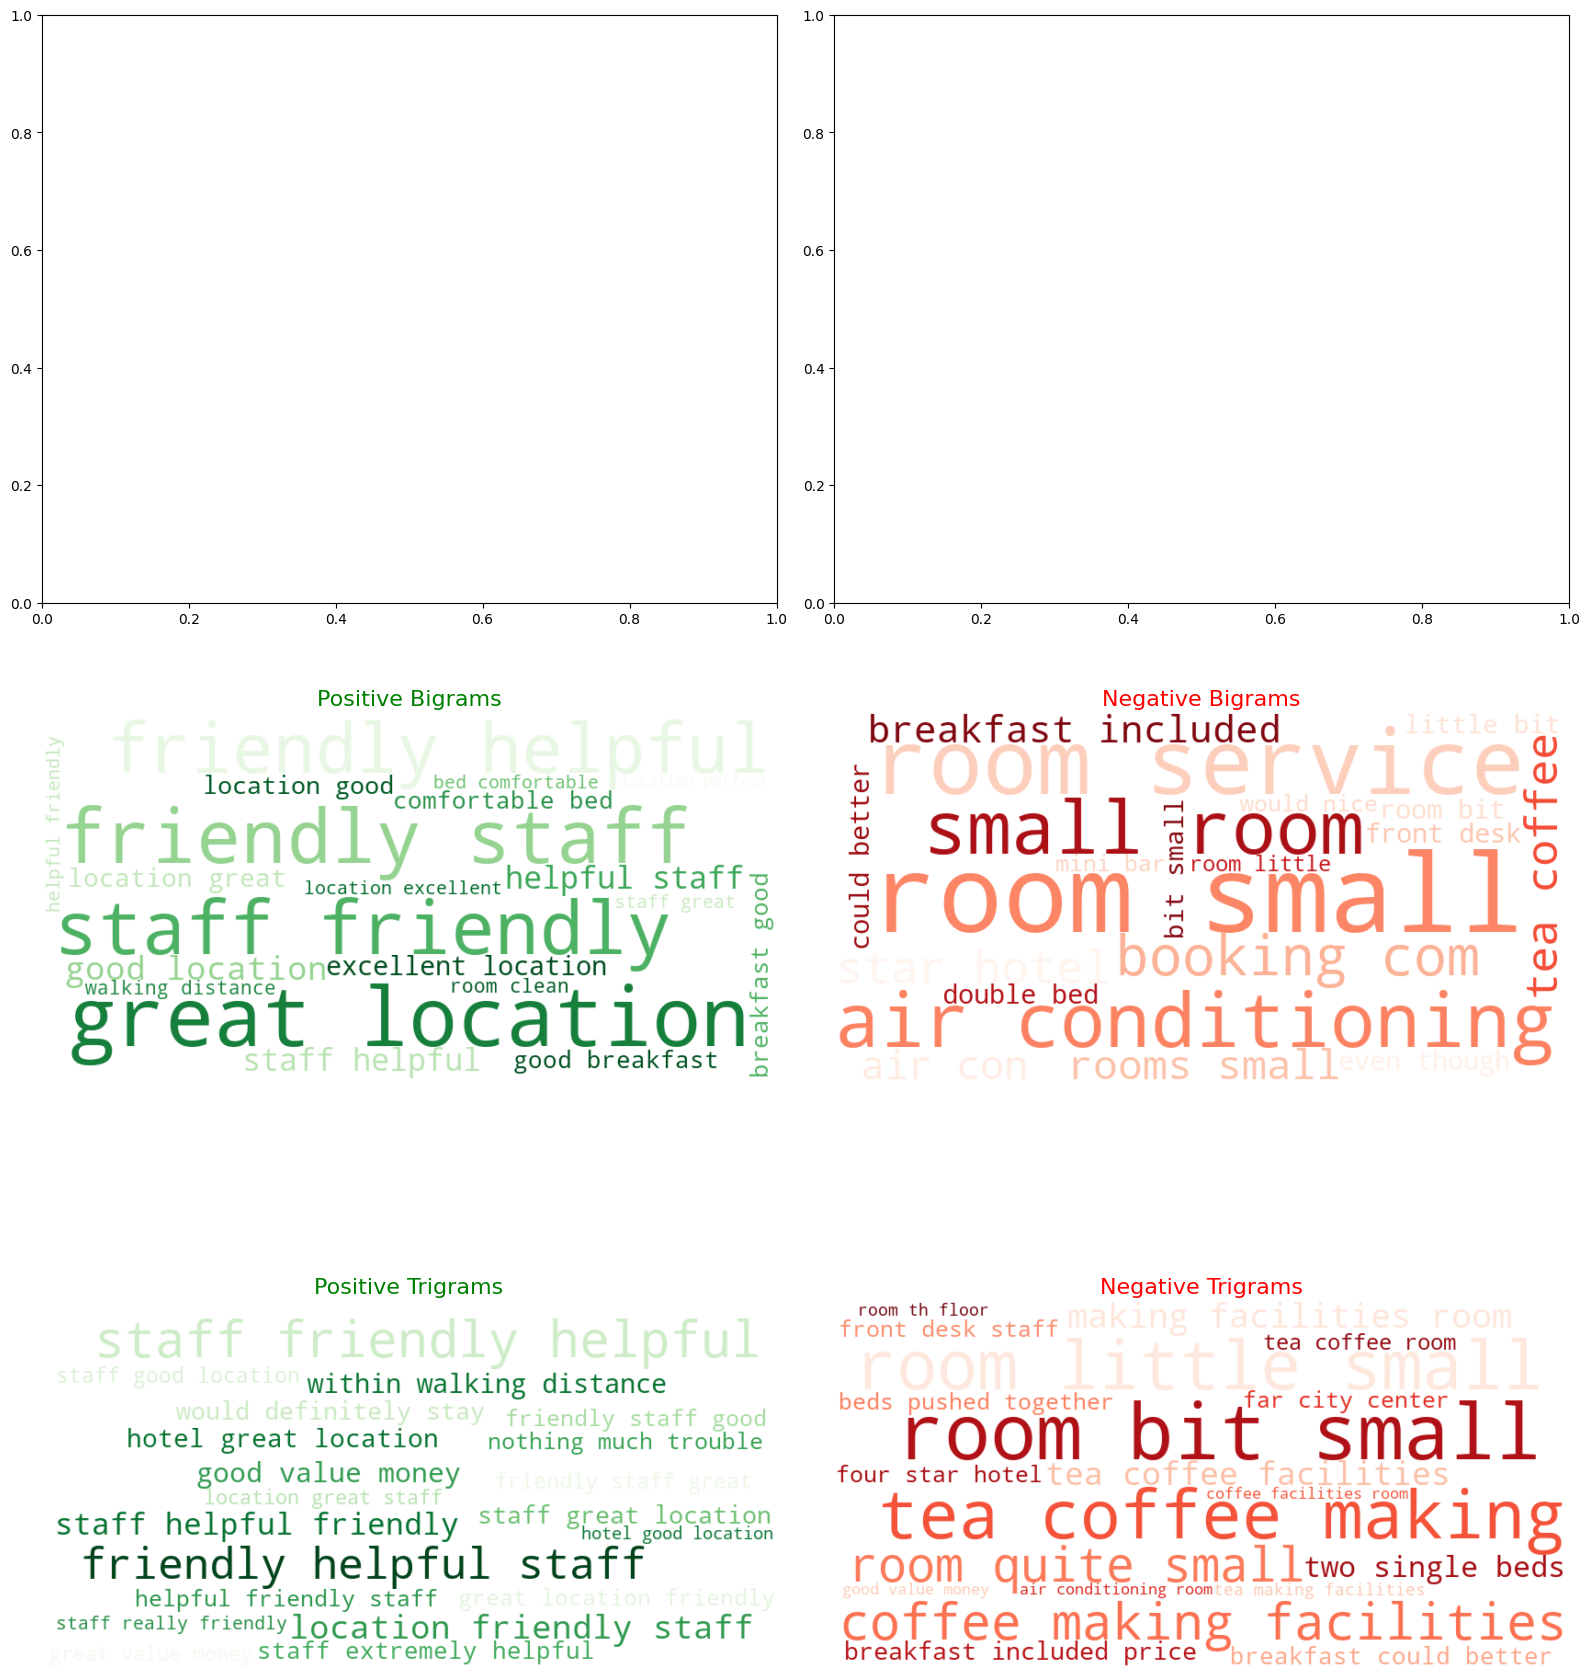

In [63]:
# -----------------------
# Generate word clouds
# -----------------------
wc_pos_bi_b = generate_wordcloud(top_pos_bigrams_b, color="green")
wc_neg_bi_b = generate_wordcloud(top_neg_bigrams_b, color="red")

wc_pos_tri_b = generate_wordcloud(top_pos_trigrams_b, color="green")
wc_neg_tri_b = generate_wordcloud(top_neg_trigrams_b, color="red")

# -----------------------
# Plot all six together
# -----------------------
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Bigrams
axes[1,0].imshow(wc_pos_bi_b, interpolation="bilinear")
axes[1,0].axis("off")
axes[1,0].set_title("Positive Bigrams", fontsize=16, color="green")

axes[1,1].imshow(wc_neg_bi_b, interpolation="bilinear")
axes[1,1].axis("off")
axes[1,1].set_title("Negative Bigrams", fontsize=16, color="red")

# Trigrams
axes[2,0].imshow(wc_pos_tri_b, interpolation="bilinear")
axes[2,0].axis("off")
axes[2,0].set_title("Positive Trigrams", fontsize=16, color="green")

axes[2,1].imshow(wc_neg_tri_b, interpolation="bilinear")
axes[2,1].axis("off")
axes[2,1].set_title("Negative Trigrams", fontsize=16, color="red")

plt.tight_layout()
plt.show()

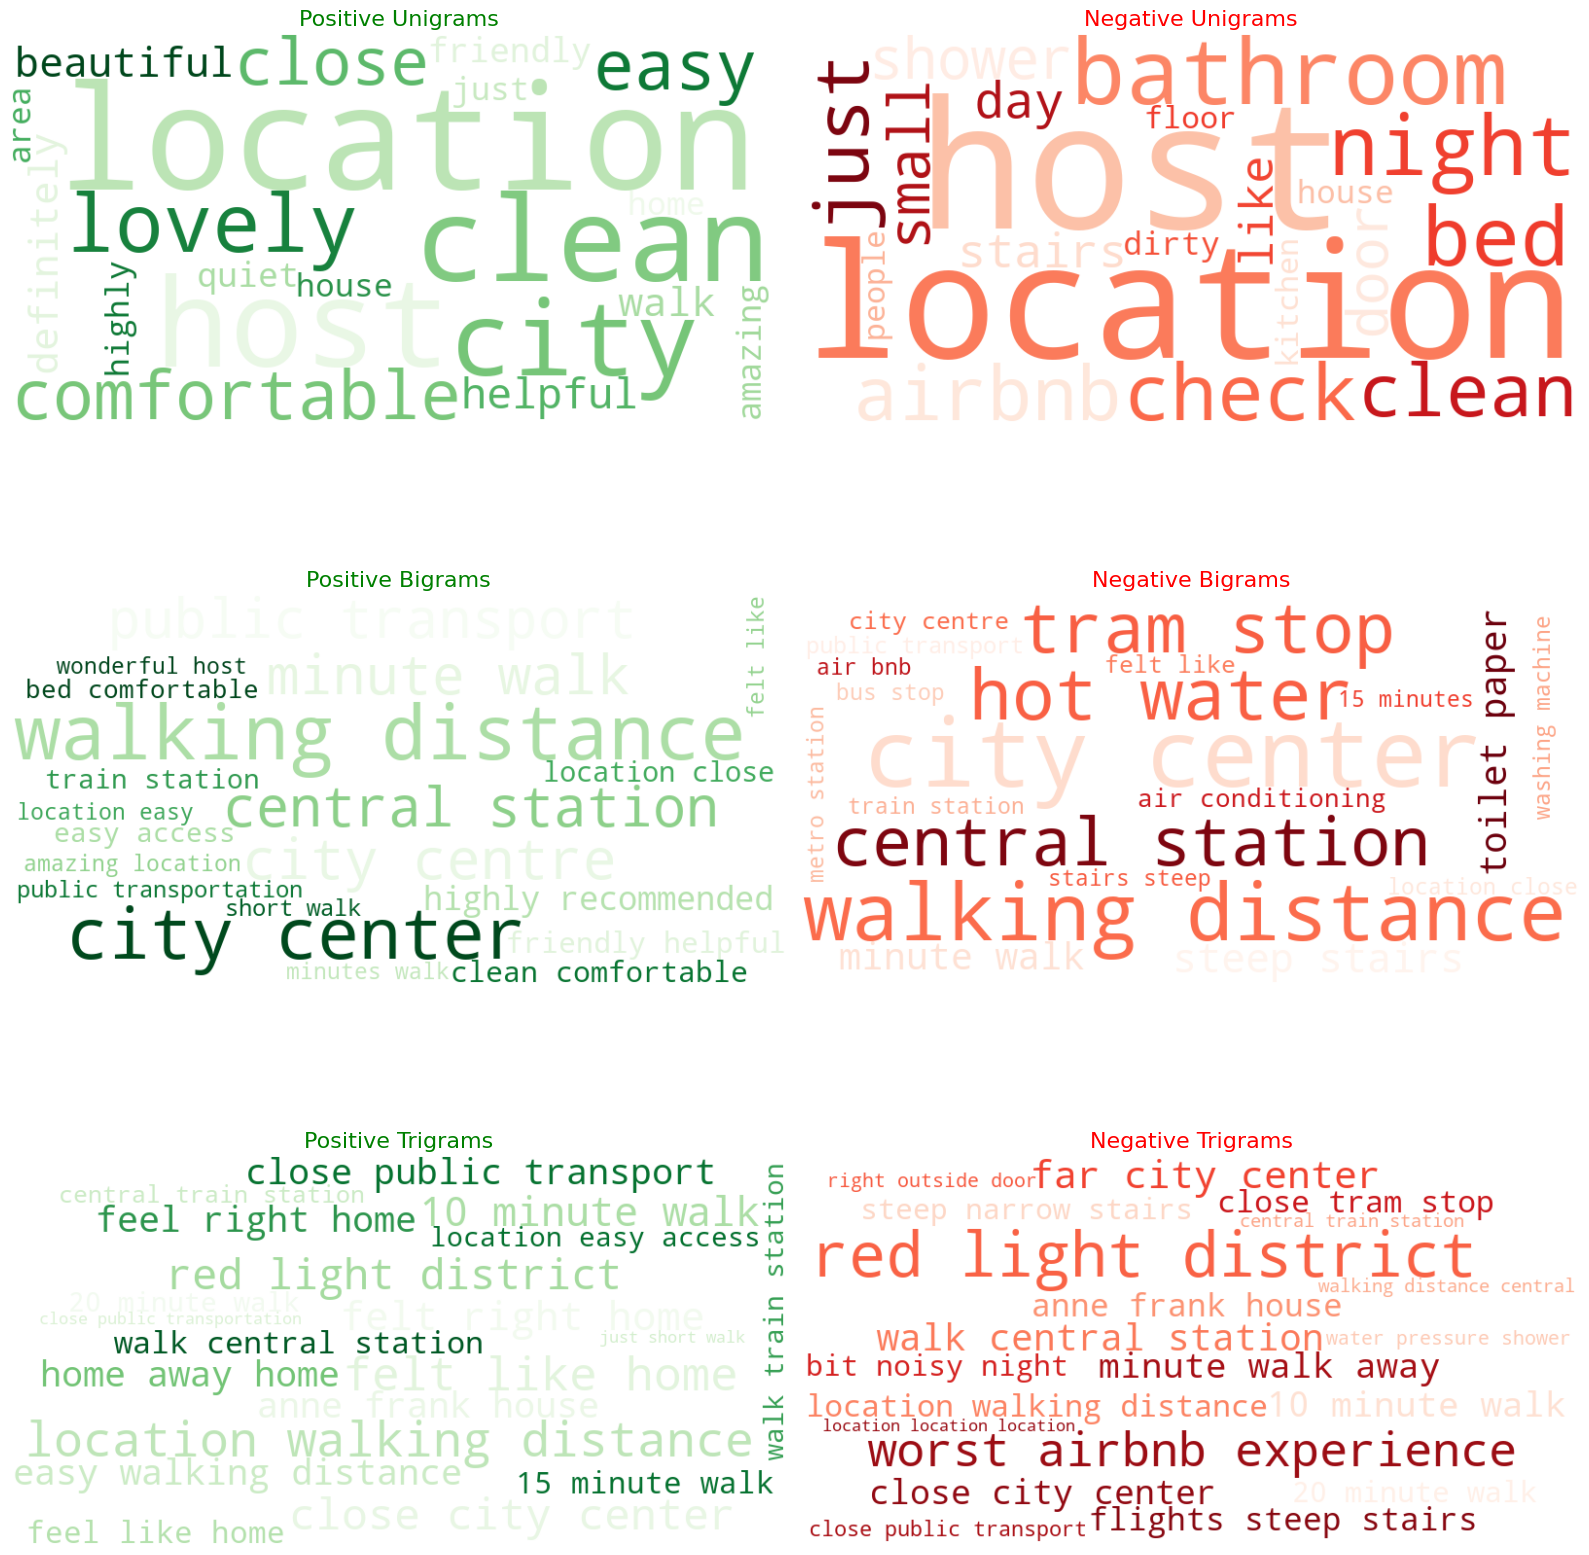

In [64]:
# -----------------------
# Generate word clouds
# -----------------------
wc_pos_uni_a = generate_wordcloud(top_pos_unigrams_a, color="green")
wc_neg_uni_a = generate_wordcloud(top_neg_unigrams_a, color="red")

wc_pos_bi_a = generate_wordcloud(top_pos_bigrams_a, color="green")
wc_neg_bi_a = generate_wordcloud(top_neg_bigrams_a, color="red")

wc_pos_tri_a = generate_wordcloud(top_pos_trigrams_a, color="green")
wc_neg_tri_a = generate_wordcloud(top_neg_trigrams_a, color="red")

# -----------------------
# Plot all six together
# -----------------------
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Unigrams
axes[0,0].imshow(wc_pos_uni_a, interpolation="bilinear")
axes[0,0].axis("off")
axes[0,0].set_title("Positive Unigrams", fontsize=16, color="green")

axes[0,1].imshow(wc_neg_uni_a, interpolation="bilinear")
axes[0,1].axis("off")
axes[0,1].set_title("Negative Unigrams", fontsize=16, color="red")

# Bigrams
axes[1,0].imshow(wc_pos_bi_a, interpolation="bilinear")
axes[1,0].axis("off")
axes[1,0].set_title("Positive Bigrams", fontsize=16, color="green")

axes[1,1].imshow(wc_neg_bi_a, interpolation="bilinear")
axes[1,1].axis("off")
axes[1,1].set_title("Negative Bigrams", fontsize=16, color="red")

# Trigrams
axes[2,0].imshow(wc_pos_tri_a, interpolation="bilinear")
axes[2,0].axis("off")
axes[2,0].set_title("Positive Trigrams", fontsize=16, color="green")

axes[2,1].imshow(wc_neg_tri_a, interpolation="bilinear")
axes[2,1].axis("off")
axes[2,1].set_title("Negative Trigrams", fontsize=16, color="red")

plt.tight_layout()
plt.show()